In [2]:
# HIDDEN MARKOV MODEL (HMM) – FULL END-TO-END MINI PROJECT IN ONE CELL
#
# Contents:
# 1. Problem Story: Weather → Ground Condition (Hidden vs Observed)
# 2. HMM Definition (states, observations, π, A, B)
# 3. Utilities: simulate HMM (hidden + observed sequences)
# 4. Forward Algorithm (sequence likelihood)
# 5. Viterbi Algorithm (most likely hidden path)
# 6. Baum–Welch Training (learn A, B, π from observations)
# 7. Evaluation & Comparison (true vs learned parameters)
# 8. Visualizations: hidden vs decoded states, matrices

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [3]:
# ============================================================
# 1. STORY & MODEL DESIGN
# ------------------------------------------------------------
# Hidden states: Weather
#   0: Sunny
#   1: Rainy
# Observations: Ground condition
#   0: Dry
#   1: Damp
#   2: Wet
#
# Intuition:
#   - On sunny days the ground is mostly dry, sometimes damp, rarely wet
#   - On rainy days the ground is often wet, sometimes damp, rarely dry
# ============================================================

hidden_states = ["Sunny", "Rainy"]
obs_symbols   = ["Dry", "Damp", "Wet"]
N = len(hidden_states)   # number of hidden states
M = len(obs_symbols)     # number of observation symbols

# True HMM parameters (ground-truth)
pi_true = np.array([0.7, 0.3])  # initial distribution over states

A_true = np.array([             # state transition probabilities
    [0.8, 0.2],                 # Sunny -> (Sunny, Rainy)
    [0.3, 0.7]                  # Rainy -> (Sunny, Rainy)
])

B_true = np.array([             # emission probabilities
    [0.7, 0.2, 0.1],            # Sunny -> (Dry, Damp, Wet)
    [0.1, 0.3, 0.6]             # Rainy -> (Dry, Damp, Wet)
])

In [4]:
# ============================================================
# 2. HMM SIMULATION – GENERATE HIDDEN + OBSERVED SEQUENCES
# ============================================================

def simulate_hmm(pi, A, B, T, rng=None):
    """
    Simulate a length-T sequence from an HMM.
    Returns:
        hidden_seq: length-T array of hidden state indices
        obs_seq:    length-T array of observation indices
    """
    if rng is None:
        rng = np.random.default_rng()
    N = A.shape[0]
    M = B.shape[1]

    hidden_seq = np.zeros(T, dtype=int)
    obs_seq = np.zeros(T, dtype=int)

    # initial state
    hidden_seq[0] = rng.choice(N, p=pi)
    obs_seq[0] = rng.choice(M, p=B[hidden_seq[0]])

    # transitions
    for t in range(1, T):
        hidden_seq[t] = rng.choice(N, p=A[hidden_seq[t-1]])
        obs_seq[t] = rng.choice(M, p=B[hidden_seq[t]])

    return hidden_seq, obs_seq

T = 80
rng = np.random.default_rng(42)
hidden_seq_true, obs_seq = simulate_hmm(pi_true, A_true, B_true, T, rng=rng)

print("Generated observation sequence (symbols):")
print([obs_symbols[o] for o in obs_seq][:25], " ...")
print()

Generated observation sequence (symbols):
['Wet', 'Wet', 'Wet', 'Damp', 'Dry', 'Wet', 'Damp', 'Dry', 'Dry', 'Wet', 'Damp', 'Wet', 'Damp', 'Dry', 'Dry', 'Wet', 'Dry', 'Dry', 'Dry', 'Dry', 'Damp', 'Dry', 'Wet', 'Damp', 'Damp']  ...



In [5]:
# ============================================================
# 3. FORWARD ALGORITHM – SEQUENCE LIKELIHOOD p(O | λ)
# ============================================================

def forward_algorithm(pi, A, B, obs_seq):
    """
    Forward algorithm for HMM.
    Returns:
        alpha: matrix of shape (T, N) with alpha[t, i] = P(o0..t, x_t=i)
        log_likelihood: log P(obs_seq | HMM)
    """
    T = len(obs_seq)
    N = A.shape[0]
    alpha = np.zeros((T, N))

    # initialization
    alpha[0] = pi * B[:, obs_seq[0]]

    # induction
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = B[j, obs_seq[t]] * np.sum(alpha[t-1] * A[:, j])

    # likelihood
    likelihood = np.sum(alpha[-1])
    log_likelihood = np.log(likelihood + 1e-300)  # avoid log(0)
    return alpha, log_likelihood

alpha_true, loglik_true = forward_algorithm(pi_true, A_true, B_true, obs_seq)
print("Log-likelihood of the generated sequence under TRUE parameters:", loglik_true)
print()

Log-likelihood of the generated sequence under TRUE parameters: -79.19469209508489



In [6]:
# ============================================================
# 4. VITERBI ALGORITHM – MOST LIKELY HIDDEN PATH
# ============================================================

def viterbi(pi, A, B, obs_seq):
    """
    Viterbi algorithm for HMM.
    Returns:
        best_path: most likely sequence of hidden states (indices)
        delta: log-probs of best paths ending in each state
    """
    T = len(obs_seq)
    N = A.shape[0]
    delta = np.zeros((T, N))   # best score (log) up to time t, ending in state i
    psi = np.zeros((T, N), dtype=int)  # backpointers

    # initialization (log space)
    delta[0] = np.log(pi + 1e-300) + np.log(B[:, obs_seq[0]] + 1e-300)

    # recursion
    for t in range(1, T):
        for j in range(N):
            scores = delta[t-1] + np.log(A[:, j] + 1e-300)
            psi[t, j] = np.argmax(scores)
            delta[t, j] = np.max(scores) + np.log(B[j, obs_seq[t]] + 1e-300)

    # termination
    best_last_state = np.argmax(delta[-1])
    best_path = np.zeros(T, dtype=int)
    best_path[-1] = best_last_state
    for t in reversed(range(1, T)):
        best_path[t-1] = psi[t, best_path[t]]

    return best_path, delta

viterbi_path, delta = viterbi(pi_true, A_true, B_true, obs_seq)
print("First 20 TRUE hidden states:   ", [hidden_states[s] for s in hidden_seq_true[:20]])
print("First 20 VITERBI decoded states:", [hidden_states[s] for s in viterbi_path[:20]])
print()

First 20 TRUE hidden states:    ['Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny']
First 20 VITERBI decoded states: ['Rainy', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny', 'Sunny']



In [7]:
# ============================================================
# 5. BAUM–WELCH TRAINING (EM ALGORITHM) – LEARNING HMM PARAMS
# ------------------------------------------------------------
# We will start from rough random parameters and try to recover
# something close to the true A, B, π from ONLY the observations.
# ============================================================

def baum_welch(obs_seq, N, M, n_iter=20, rng=None):
    """
    Baum–Welch algorithm (EM) for training HMM.
    obs_seq: array of ints (T,)
    N: number of hidden states
    M: number of observation symbols
    Returns:
        pi, A, B (learned)
    """
    if rng is None:
        rng = np.random.default_rng()

    T = len(obs_seq)

    # Random initialization
    pi = rng.dirichlet(np.ones(N))
    A = rng.dirichlet(np.ones(N), size=N)
    B = rng.dirichlet(np.ones(M), size=N)

    for iteration in range(n_iter):
        # E-step: compute alpha, beta, gamma, xi

        # Forward
        alpha = np.zeros((T, N))
        alpha[0] = pi * B[:, obs_seq[0]]
        for t in range(1, T):
            for j in range(N):
                alpha[t, j] = B[j, obs_seq[t]] * np.sum(alpha[t-1] * A[:, j])
        scale_factors = alpha.sum(axis=1, keepdims=True) + 1e-300
        alpha /= scale_factors  # scaling for numerical stability

        # Backward
        beta = np.zeros((T, N))
        beta[-1] = 1.0
        for t in reversed(range(T-1)):
            for i in range(N):
                beta[t, i] = np.sum(A[i] * B[:, obs_seq[t+1]] * beta[t+1])
            beta[t] /= (beta[t].sum() + 1e-300)

        # Gamma & Xi
        gamma = (alpha * beta)
        gamma /= gamma.sum(axis=1, keepdims=True) + 1e-300

        xi = np.zeros((T-1, N, N))
        for t in range(T-1):
            denom = np.sum(alpha[t][:, None] * A * B[:, obs_seq[t+1]][None, :] * beta[t+1][None, :]) + 1e-300
            for i in range(N):
                numer = alpha[t, i] * A[i] * B[:, obs_seq[t+1]] * beta[t+1]
                xi[t, i] = numer / denom

        # M-step: re-estimate pi, A, B
        pi = gamma[0]

        A = xi.sum(axis=0)
        A /= A.sum(axis=1, keepdims=True) + 1e-300

        B = np.zeros((N, M))
        for j in range(N):
            for k in range(M):
                mask = (obs_seq == k)
                B[j, k] = gamma[mask, j].sum()
        B /= B.sum(axis=1, keepdims=True) + 1e-300

    return pi, A, B

pi_learned, A_learned, B_learned = baum_welch(obs_seq, N=N, M=M, n_iter=30, rng=rng)

print("TRUE π:     ", pi_true)
print("LEARNED π:  ", pi_learned)
print()
print("TRUE A:\n", A_true)
print("LEARNED A:\n", A_learned)
print()
print("TRUE B:\n", B_true)
print("LEARNED B:\n", B_learned)
print()

# Likelihood under learned vs true
_, loglik_learned = forward_algorithm(pi_learned, A_learned, B_learned, obs_seq)
print("Log-likelihood under TRUE params:   ", loglik_true)
print("Log-likelihood under LEARNED params:", loglik_learned)
print()

TRUE π:      [0.7 0.3]
LEARNED π:   [0. 1.]

TRUE A:
 [[0.8 0.2]
 [0.3 0.7]]
LEARNED A:
 [[0.945 0.055]
 [0.338 0.662]]

TRUE B:
 [[0.7 0.2 0.1]
 [0.1 0.3 0.6]]
LEARNED B:
 [[0.653 0.216 0.131]
 [0.117 0.196 0.687]]

Log-likelihood under TRUE params:    -79.19469209508489
Log-likelihood under LEARNED params: -76.27108630801435



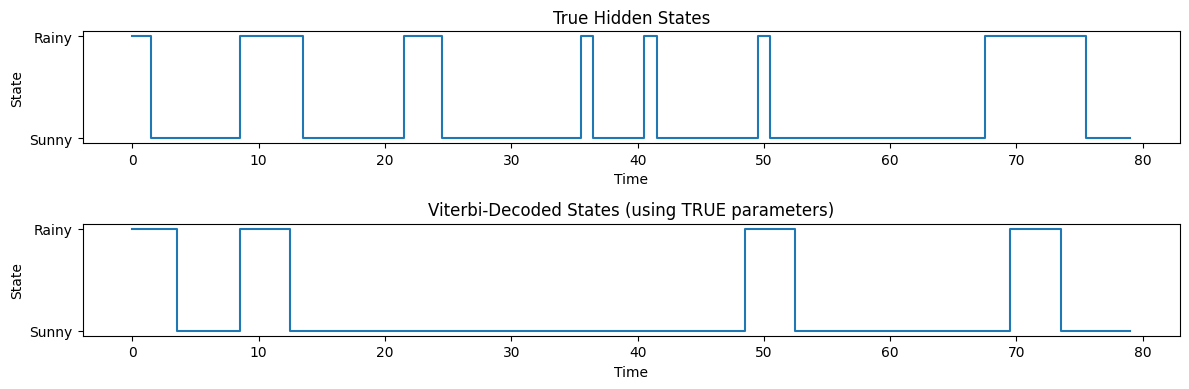

In [8]:
# ============================================================
# 6. VISUALIZATIONS
# ------------------------------------------------------------
# (A) Hidden vs Viterbi-decoded states over time
# (B) True vs learned transition matrices
# (C) True vs learned emission matrices
# ============================================================

time = np.arange(T)

plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.step(time, hidden_seq_true, where="mid")
plt.yticks([0, 1], hidden_states)
plt.title("True Hidden States")
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(2, 1, 2)
plt.step(time, viterbi_path, where="mid")
plt.yticks([0, 1], hidden_states)
plt.title("Viterbi-Decoded States (using TRUE parameters)")
plt.xlabel("Time")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [9]:
# Heatmap-like visualization using imshow (without custom colors)
def plot_matrix_compare(true_mat, learned_mat, title_true, title_learned, xticklabels, yticklabels):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(true_mat, aspect='auto')
    plt.title(title_true)
    plt.xticks(range(len(xticklabels)), xticklabels)
    plt.yticks(range(len(yticklabels)), yticklabels)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 2, 2)
    plt.imshow(learned_mat, aspect='auto')
    plt.title(title_learned)
    plt.xticks(range(len(xticklabels)), xticklabels)
    plt.yticks(range(len(yticklabels)), yticklabels)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

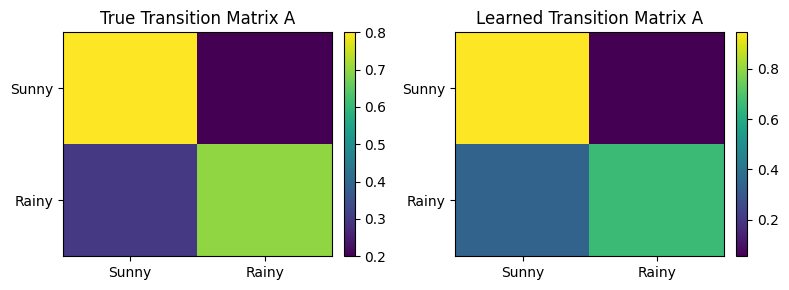

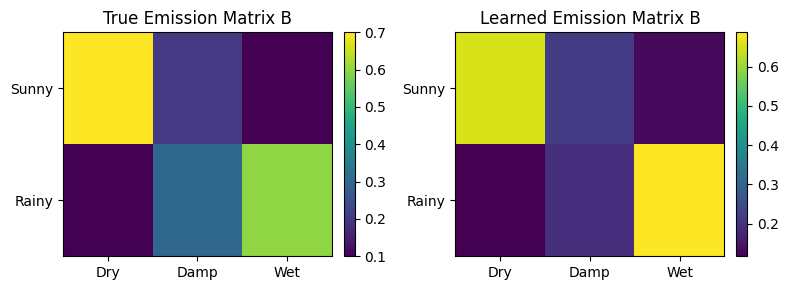

End-to-end HMM project completed: simulation, forward, Viterbi, Baum–Welch, and visualization.


In [10]:
# Transition matrices
plot_matrix_compare(
    A_true, A_learned,
    title_true="True Transition Matrix A",
    title_learned="Learned Transition Matrix A",
    xticklabels=hidden_states,
    yticklabels=hidden_states
)

# Emission matrices
plot_matrix_compare(
    B_true, B_learned,
    title_true="True Emission Matrix B",
    title_learned="Learned Emission Matrix B",
    xticklabels=obs_symbols,
    yticklabels=hidden_states
)

print("End-to-end HMM project completed: simulation, forward, Viterbi, Baum–Welch, and visualization.")